In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.offsets import DateOffset
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
# all imports done

In [169]:
# Load and preprocess data
df = pd.read_csv('../DATA/long_dat.csv')
df['Year'] = pd.to_datetime(df['Year'], format='%Y')  # Convert to datetime
df = df.sort_values(['Continent', 'Year'])

In [170]:
continents = df["Continent"].unique()

# Set up proper time index for each continent
def prepare_ts(continent_df):
    ts = continent_df.set_index('Year')['Alc']
    return ts.asfreq('AS')


Analyzing Africa
ADF p-value (d=0): 0.2428
Applied differencing (d=1), new length: 0
Insufficient data after cleaning
Insufficient data for modeling - using baseline


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


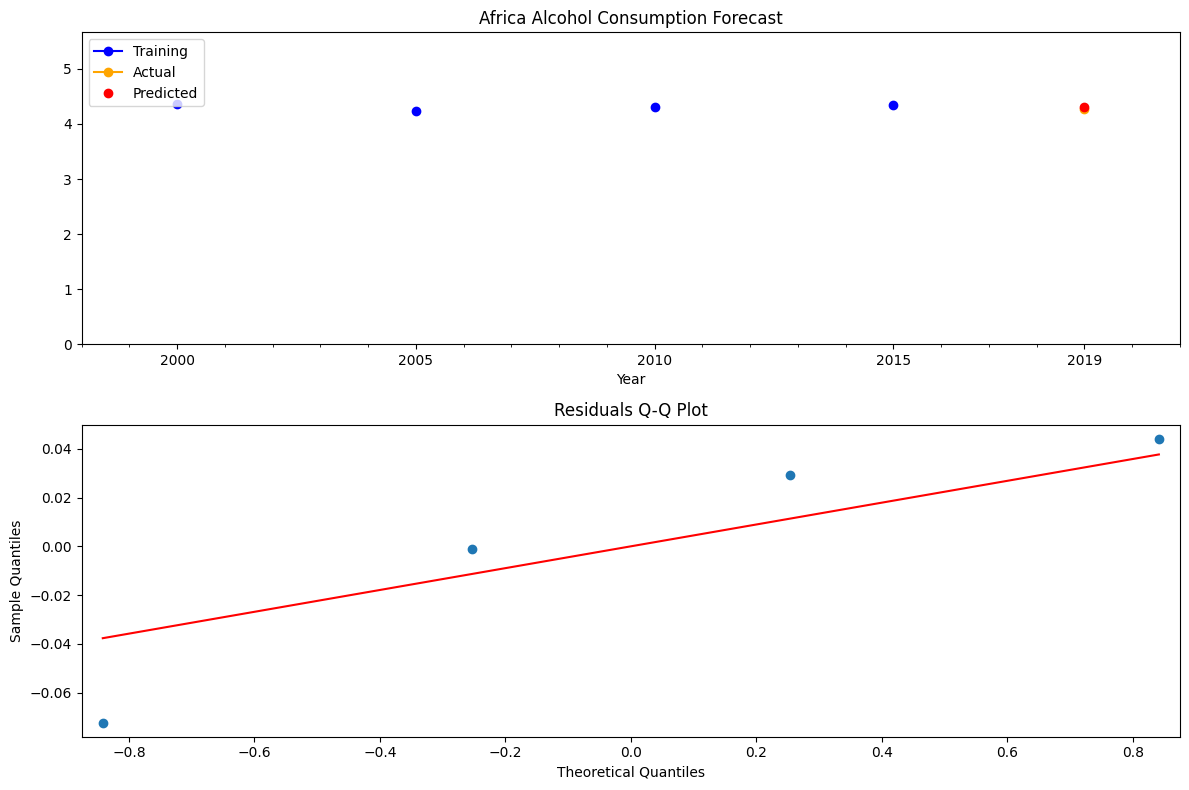


Analyzing Asia
ADF p-value (d=0): 0.9979
Applied differencing (d=1), new length: 0
Insufficient data after cleaning
Insufficient data for modeling - using baseline


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')


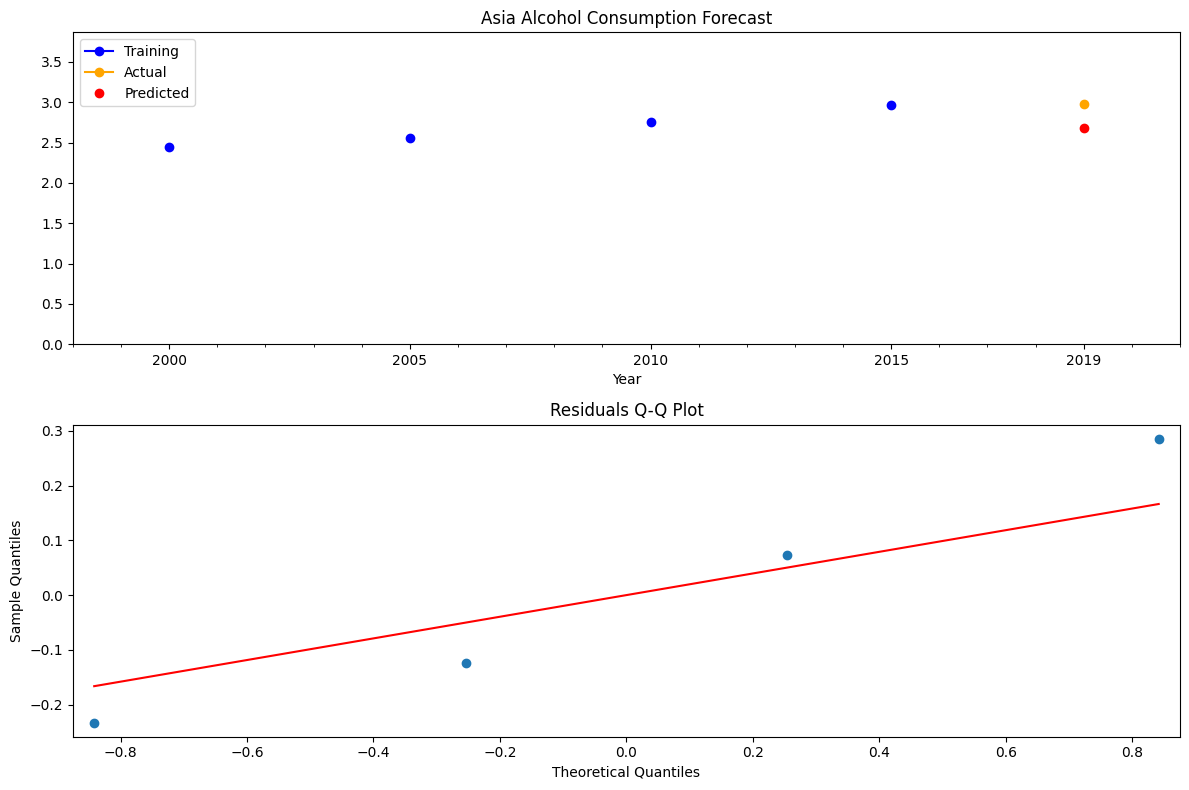


Analyzing Europe
ADF p-value (d=0): 0.9453
Applied differencing (d=1), new length: 0
Insufficient data after cleaning
Insufficient data for modeling - using baseline


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')


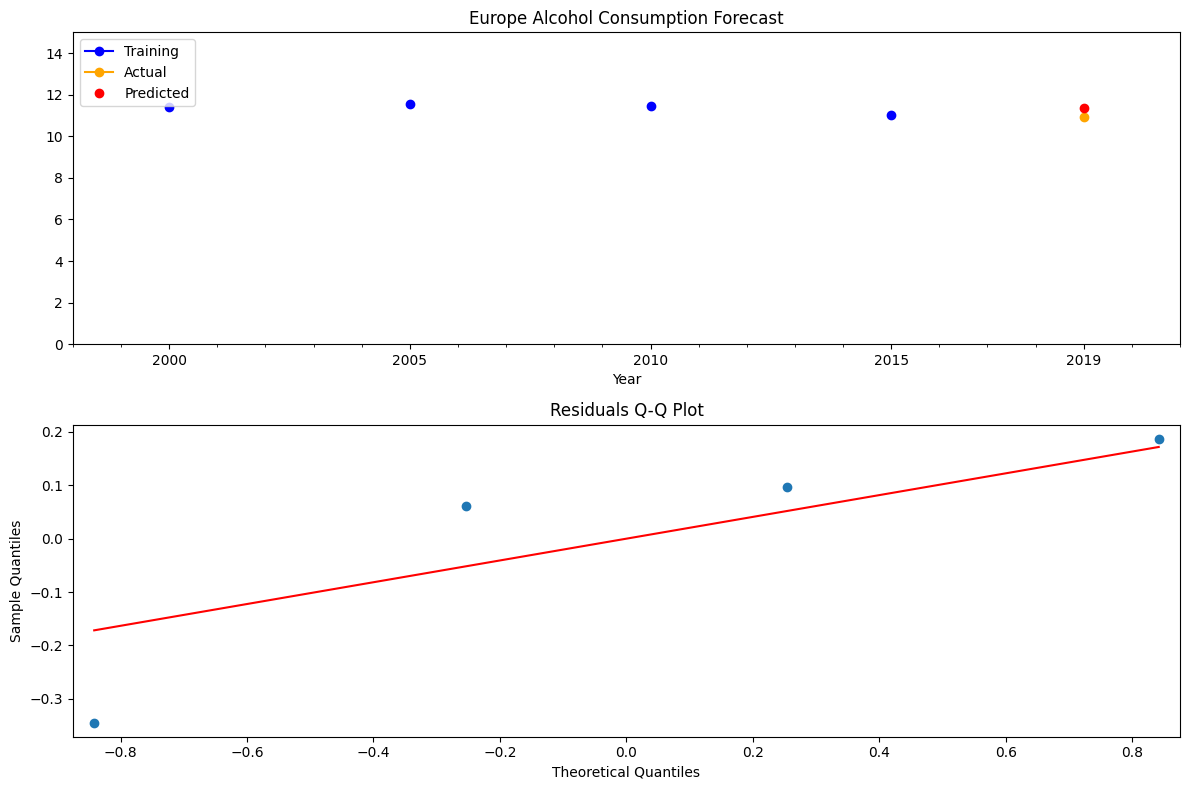

In [171]:
# Initialize results storage
results = {}

for continent in continents:
    print(f"\n{'='*40}\nAnalyzing {continent}\n{'='*40}")

    # Prepare time series
    continent_data = df[df["Continent"] == continent]
    ts = prepare_ts(continent_data)

    # Train-test split
    train = ts[:"2015"]
    test = ts["2019":]

    # Stationarity check
    d = 0
    current_series = train.copy()
    max_possible_d = len(train) - 3  # Ensure minimum 3 points remain

    while d <= max_possible_d:
        clean_series = current_series.dropna()
        if len(clean_series) < 3:
            print("Insufficient data after cleaning")
            break
        try:
            adf_result = adfuller(clean_series, maxlag=0)
        except Exception as e:
            print(f"ADF test failed: {str(e)}")
            break
        print(f"ADF p-value (d={d}): {adf_result[1]:.4f}")
        if adf_result[1] > 0.05 and d < max_possible_d:
            d += 1
            current_series = current_series.diff().dropna()
            print(f"Applied differencing (d={d}), new length: {len(current_series)}")
        else:
            break

    if len(current_series) < 3:
        print("Insufficient data for modeling - using baseline")
        d = 0
        current_series = train.copy()

    if len(train) <= 5:
        model_order = (0, d, 0)
        print("Using simple ARIMA(0,{},0) due to small sample".format(d))
    else:
        model = auto_arima(
            train, seasonal=False, stepwise=True, suppress_warnings=True, d=d
        )
        model_order = model.order

    # Fit model and forecast
    final_model = ARIMA(train, order=model_order)
    model_fit = final_model.fit()
    forecast = model_fit.get_forecast(steps=1)

    # Ensure correct forecasting date
    forecast_index = [pd.Timestamp("2019-01-01")]
    forecast_values = pd.Series(forecast.predicted_mean.values, index=forecast_index)

    # Store results
    results[continent] = {
        "actual": test.iloc[0] if not test.empty else np.nan,
        "predicted": forecast_values.iloc[0],
        "order": model_order,
        "residuals": model_fit.resid,
        "aic": model_fit.aic,
        "lb_test": acorr_ljungbox(model_fit.resid, lags=[1], return_df=True),
        "adf_pvalue": adf_result[1],
    }

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # Main forecast plot
    train.plot(ax=ax[0], label="Training", marker="o", color="blue")
    if not test.empty:
        test.plot(ax=ax[0], label="Actual", marker="o", color="orange")
    forecast_values.plot(ax=ax[0], style="ro", label="Predicted")

    # Set x-axis limits for spacing
    start_year = train.index.min().year - 2  # Extra space before 2000
    end_year = 2019 + 2  # Extra space after 2019
    ax[0].set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-01-01"))

    # Set specific year labels
    years = [2000, 2005, 2010, 2015, 2019]
    ax[0].set_xticks([pd.Timestamp(f"{year}-01-01") for year in years])
    ax[0].set_xticklabels(years)  # Directly set the labels to be years

    # Adjust y-axis scale
    y_min = 0
    y_max = (
        max(train.max(), test.max() if not test.empty else 0, forecast_values.max()) * 1.3
    )  # 30% padding
    ax[0].set_ylim(y_min, y_max)

    # Titles & legend
    ax[0].set_title(f"{continent} Alcohol Consumption Forecast")
    ax[0].legend(loc="upper left")

    # Improved Q-Q plot
    qqplot(results[continent]["residuals"].dropna(), line="s", ax=ax[1])
    ax[1].set_title("Residuals Q-Q Plot")

    plt.tight_layout()
    plt.show()

In [172]:
# Calculate evaluation metrics
mae_values = []
rmse_values = []

print("\n\nModel Evaluation:")
for continent in continents:
    actual = results[continent]["actual"]
    predicted = results[continent]["predicted"]

    if not np.isnan(actual):  # Prevent errors from missing test values
        mae = mean_absolute_error([actual], [predicted])
        rmse = np.sqrt(mean_squared_error([actual], [predicted]))

        mae_values.append(mae)
        rmse_values.append(rmse)

        print(f"\n{continent}:")
        print(f"Order (p,d,q): {results[continent]['order']}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"AIC: {results[continent]['aic']:.2f}")
        print(
            f"Ljung-Box p-value: {results[continent]['lb_test']['lb_pvalue'].values[0]:.4f}"
        )

# Calculate average metrics
if mae_values:  # Avoid division by zero
    avg_mae = np.mean(mae_values)
    avg_rmse = np.mean(rmse_values)

    print("\n\nFinal Results:")
    print(f"Average MAE across continents: {avg_mae:.4f}")
    print(f"Average RMSE across continents: {avg_rmse:.4f}")

    # Success criteria
    if avg_mae <= 0.5:
        print("\nSUCCESS: Achieved target MAE ≤ 0.5")
    else:
        print("\nIMPROVEMENT NEEDED: MAE > 0.5")



Model Evaluation:

Africa:
Order (p,d,q): (0, 0, 0)
MAE: 0.0440
RMSE: 0.0440
AIC: -9.49
Ljung-Box p-value: nan

Asia:
Order (p,d,q): (0, 0, 0)
MAE: 0.2924
RMSE: 0.2924
AIC: 2.39
Ljung-Box p-value: nan

Europe:
Order (p,d,q): (0, 0, 0)
MAE: 0.4426
RMSE: 0.4426
AIC: 2.63
Ljung-Box p-value: nan


Final Results:
Average MAE across continents: 0.2597
Average RMSE across continents: 0.2597

SUCCESS: Achieved target MAE ≤ 0.5




Predicting Alcohol Consumption for 2025

Predicting 2025 for Africa

Historical Values:
  2000: 4.36
  2001: nan
  2002: nan
  2003: nan
  2004: nan
  2005: 4.24
  2006: nan
  2007: nan
  2008: nan
  2009: nan
  2010: 4.31
  2011: nan
  2012: nan
  2013: nan
  2014: nan
  2015: 4.34
  2016: nan
  2017: nan
  2018: nan
  2019: 4.27
ADF p-value (d=0): 0.0168

2025 Prediction for Africa:
  Point Estimate: 4.30
  95% Confidence Interval: (4.22, 4.39)


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')


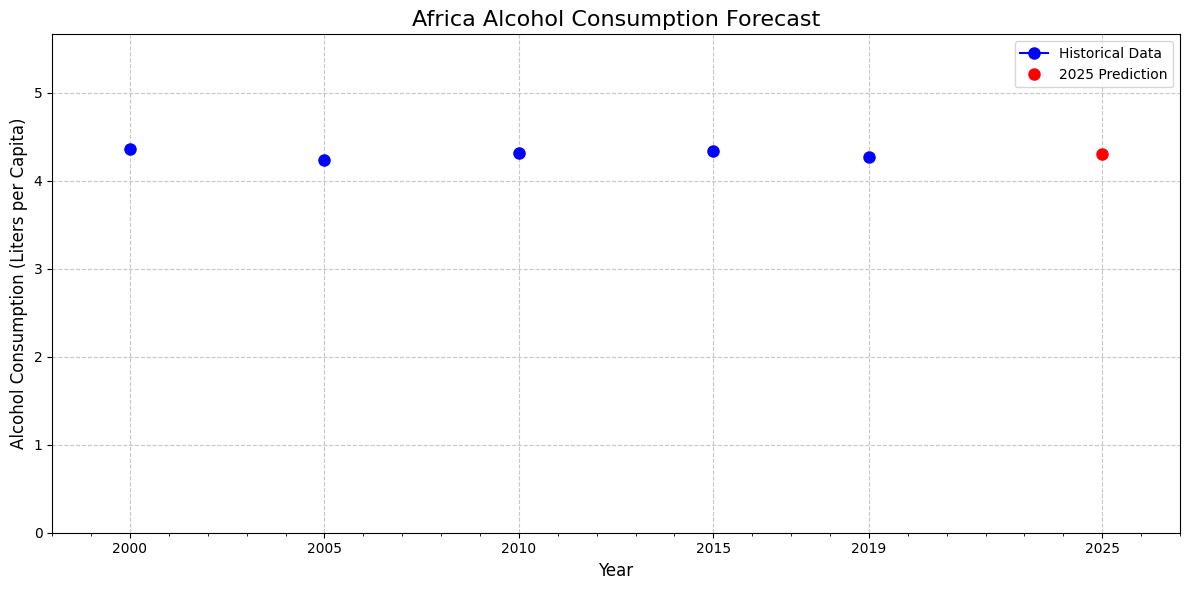

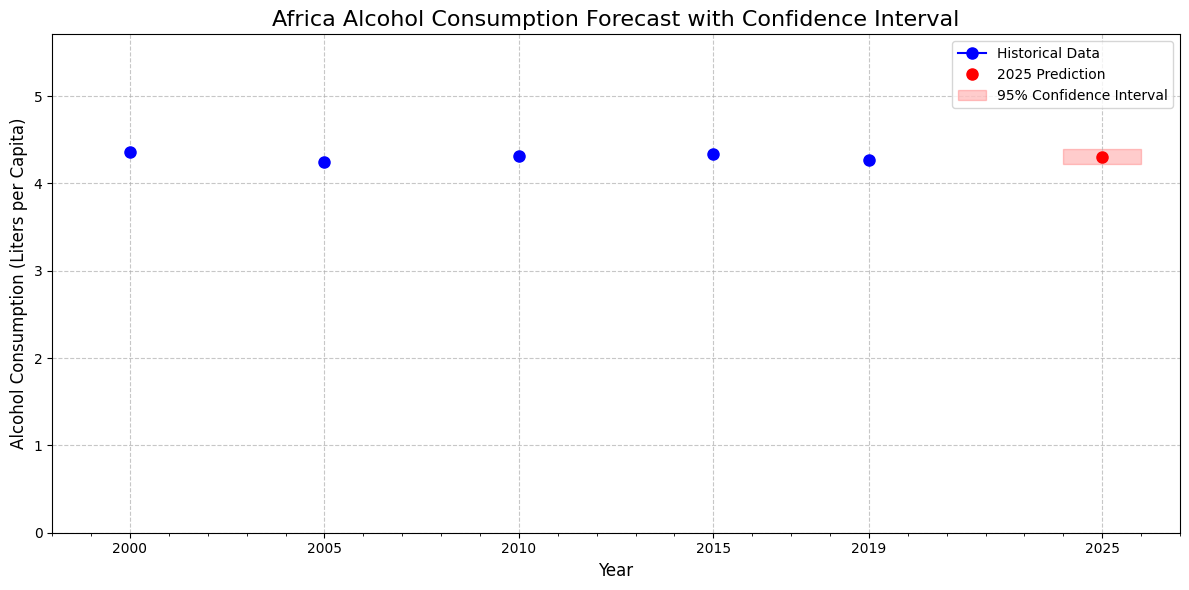


Predicting 2025 for Asia

Historical Values:
  2000: 2.45
  2001: nan
  2002: nan
  2003: nan
  2004: nan
  2005: 2.56
  2006: nan
  2007: nan
  2008: nan
  2009: nan
  2010: 2.75
  2011: nan
  2012: nan
  2013: nan
  2014: nan
  2015: 2.97
  2016: nan
  2017: nan
  2018: nan
  2019: 2.97
ADF p-value (d=0): 0.8155
Applied differencing (d=1), new length: 0
Insufficient data after cleaning
Insufficient data for modeling - using baseline


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')



2025 Prediction for Asia:
  Point Estimate: 2.91
  95% Confidence Interval: (2.60, 3.22)


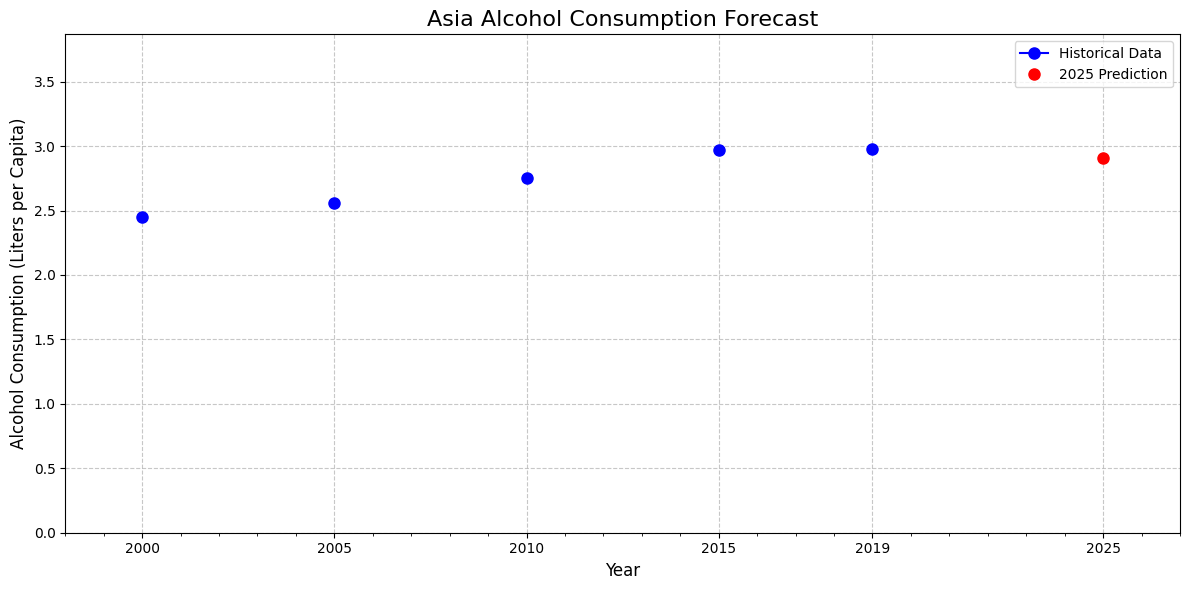

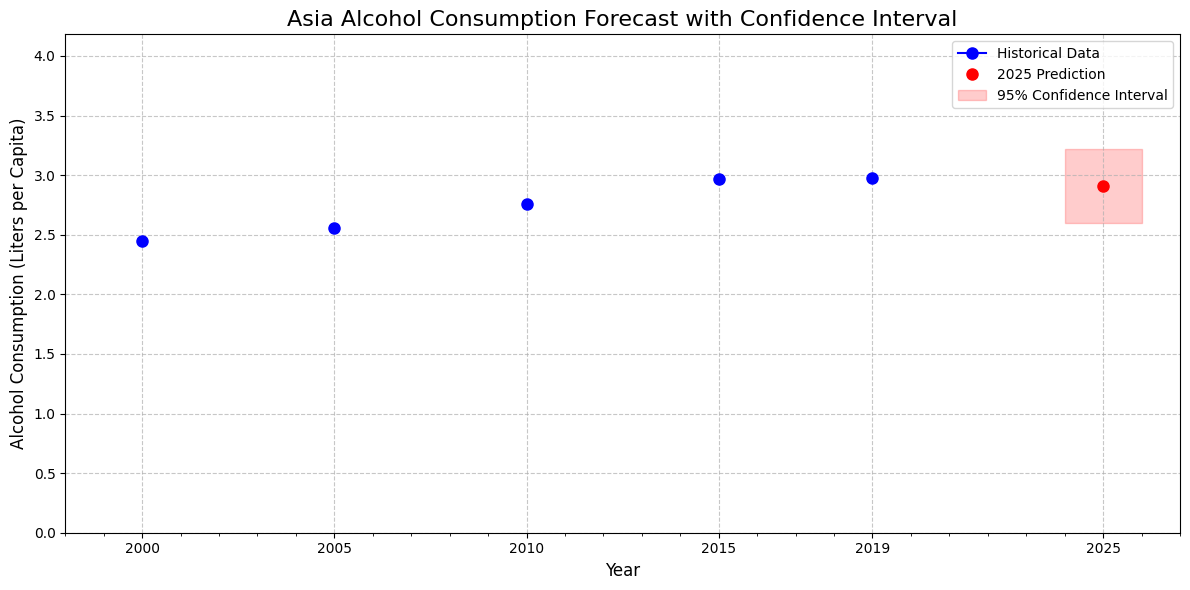


Predicting 2025 for Europe

Historical Values:
  2000: 11.41
  2001: nan
  2002: nan
  2003: nan
  2004: nan
  2005: 11.54
  2006: nan
  2007: nan
  2008: nan
  2009: nan
  2010: 11.45
  2011: nan
  2012: nan
  2013: nan
  2014: nan
  2015: 11.01
  2016: nan
  2017: nan
  2018: nan
  2019: 10.91
ADF p-value (d=0): 0.9439
Applied differencing (d=1), new length: 0
Insufficient data after cleaning
Insufficient data for modeling - using baseline

2025 Prediction for Europe:
  Point Estimate: 11.26
  95% Confidence Interval: (10.76, 11.76)


/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_35415/3620436467.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  return ts.asfreq('AS')


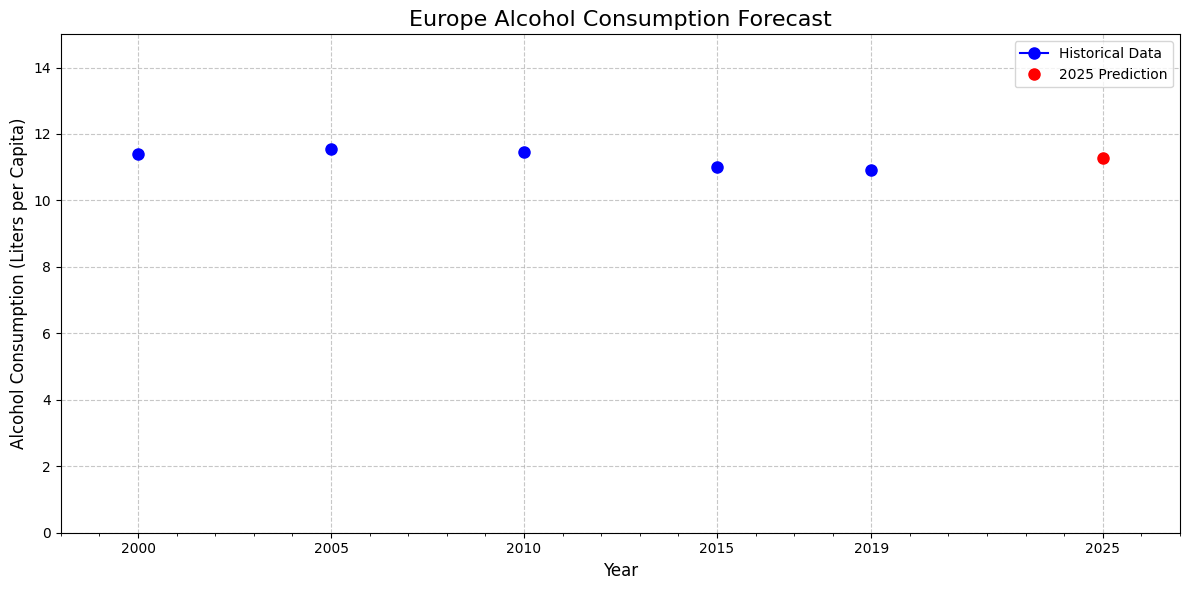

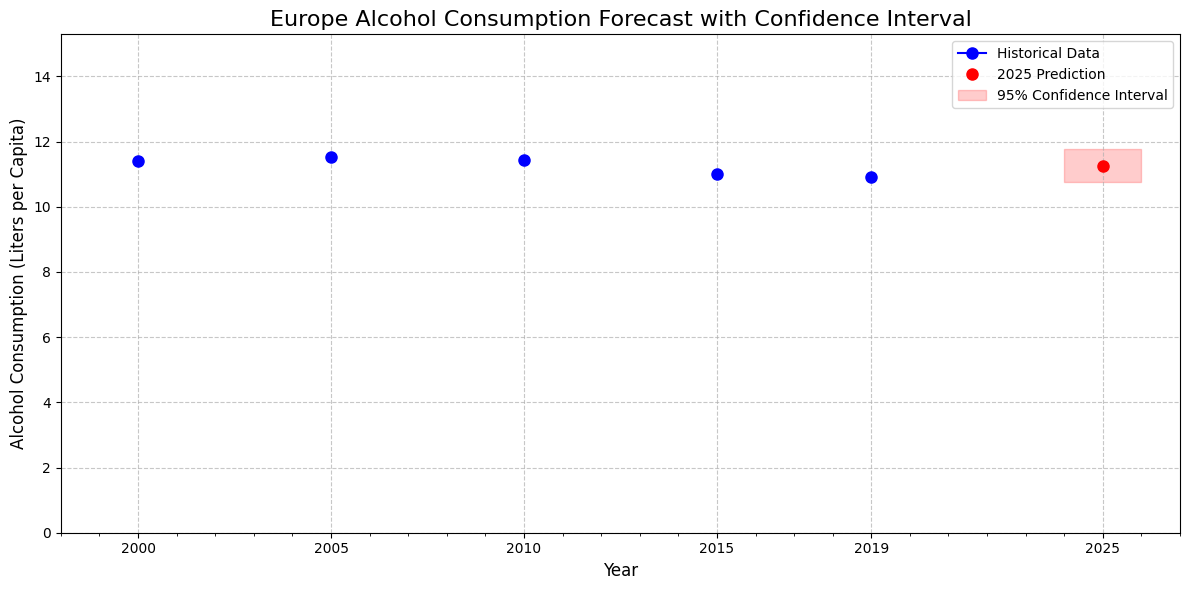



Predicted Alcohol Consumption for 2025 with 95% Confidence Intervals
Africa: 4.30 (95% CI: 4.22 - 4.39)
Asia: 2.91 (95% CI: 2.60 - 3.22)
Europe: 11.26 (95% CI: 10.76 - 11.76)


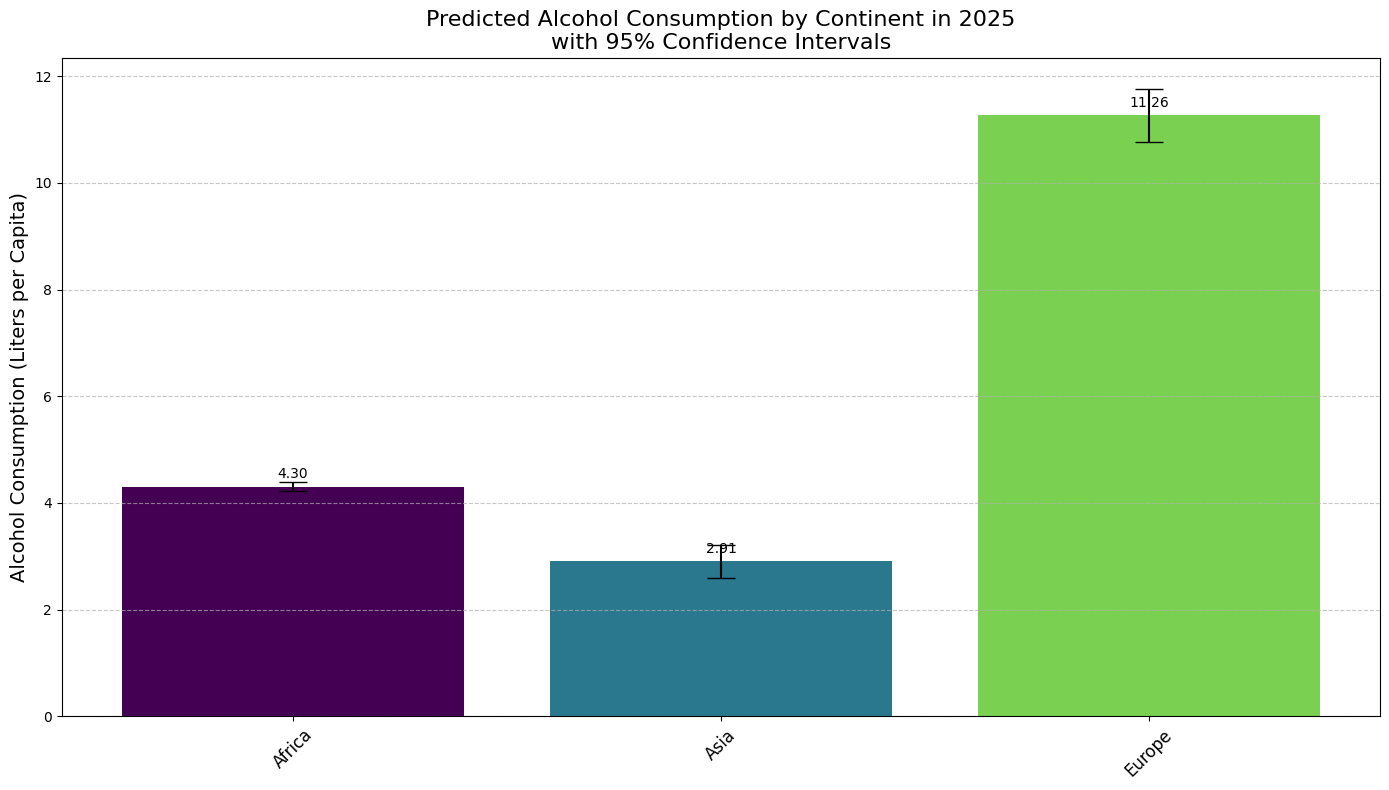

In [173]:
# Add this code to the end of your existing script to create 2025 predictions
# with additional visualizations for confidence intervals

print("\n\n" + "="*80)
print("Predicting Alcohol Consumption for 2025")
print("="*80)

# Initialize storage for 2025 predictions
predictions_2025 = {}
confidence_intervals_2025 = {}

for continent in continents:
    print(f"\n{'='*40}\nPredicting 2025 for {continent}\n{'='*40}")

    # Prepare time series - use ALL available data now
    continent_data = df[df["Continent"] == continent]
    ts = prepare_ts(continent_data)
    
    # Use all data for modeling
    full_data = ts

    # Print all historical values
    print("\nHistorical Values:")
    for year, value in full_data.items():
        print(f"  {year.year}: {value:.2f}")

    # Stationarity check and ARIMA model selection (similar to your original code)
    d = 0
    current_series = full_data.copy()
    max_possible_d = len(full_data) - 3

    while d <= max_possible_d:
        clean_series = current_series.dropna()
        if len(clean_series) < 3:
            print("Insufficient data after cleaning")
            break
        try:
            adf_result = adfuller(clean_series, maxlag=0)
        except Exception as e:
            print(f"ADF test failed: {str(e)}")
            break
        print(f"ADF p-value (d={d}): {adf_result[1]:.4f}")
        if adf_result[1] > 0.05 and d < max_possible_d:
            d += 1
            current_series = current_series.diff().dropna()
            print(f"Applied differencing (d={d}), new length: {len(current_series)}")
        else:
            break

    if len(current_series) < 3:
        print("Insufficient data for modeling - using baseline")
        d = 0
        current_series = full_data.copy()

    if len(full_data) <= 5:
        model_order = (0, d, 0)
        print("Using simple ARIMA(0,{},0) due to small sample".format(d))
    else:
        model = auto_arima(
            full_data, seasonal=False, stepwise=True, suppress_warnings=True, d=d
        )
        model_order = model.order

    # Fit model and forecast to 2025
    final_model = ARIMA(full_data, order=model_order)
    model_fit = final_model.fit()
    
    # Calculate steps to forecast from last data point to 2025
    last_data_year = full_data.index.max().year
    steps_to_2025 = 2025 - last_data_year
    
    # Generate forecast for 2025 with confidence intervals
    forecast = model_fit.get_forecast(steps=steps_to_2025)
    conf_int = forecast.conf_int()
    
    # Extract prediction and confidence intervals for 2025
    prediction_2025 = forecast.predicted_mean.values[-1]
    lower_ci = conf_int.iloc[-1, 0]
    upper_ci = conf_int.iloc[-1, 1]
    
    # Create forecast index and series
    forecast_index = [pd.Timestamp(f"{2025}-01-01")]
    forecast_value = pd.Series(prediction_2025, index=forecast_index)
    
    # Store 2025 prediction and confidence intervals
    predictions_2025[continent] = prediction_2025
    confidence_intervals_2025[continent] = (lower_ci, upper_ci)
    
    # Print 2025 prediction with confidence intervals
    print(f"\n2025 Prediction for {continent}:")
    print(f"  Point Estimate: {prediction_2025:.2f}")
    print(f"  95% Confidence Interval: ({lower_ci:.2f}, {upper_ci:.2f})")
    
    # ----- ORIGINAL PLOT (unchanged) -----
    # Plotting in the format similar to the provided image
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot historical data
    full_data.plot(ax=ax, label="Historical Data", marker="o", color="blue", linestyle="-", markersize=8)
    
    # Plot 2025 prediction
    forecast_value.plot(ax=ax, style="ro", label="2025 Prediction", markersize=8)

    # Set x-axis limits for spacing
    start_year = 1998  # Slightly before 2000
    end_year = 2027    # Slightly after 2025
    ax.set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-01-01"))

    # Set specific year labels including 2025
    years = [2000, 2005, 2010, 2015, 2019, 2025]
    ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in years])
    ax.set_xticklabels(years)

    # Adjust y-axis scale with 1.3 margin as in original code
    min_value = min(0, full_data.min() * 0.9, forecast_value.min() * 0.9)
    max_value = max(full_data.max() * 1.3, forecast_value.max() * 1.3)
    ax.set_ylim(min_value, max_value)
    
    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Titles & labels
    ax.set_title(f"{continent} Alcohol Consumption Forecast", fontsize=16)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Alcohol Consumption (Liters per Capita)", fontsize=12)
    ax.legend(loc="best")

    plt.tight_layout()
    plt.show()
    
    # ----- ADDITIONAL PLOT FOR CONFIDENCE INTERVALS -----
    # Create new plot specifically for visualizing confidence intervals
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot historical data with markers (ensure the marker="o" is included and working)
    full_data.plot(ax=ax, label="Historical Data", marker="o", color="blue", linestyle="-", markersize=8)

    # Plot 2025 prediction point
    forecast_value.plot(ax=ax, style="ro", label="2025 Prediction", markersize=8)

    # Add the confidence interval shaded region (rectangular)
    ax.fill_between([pd.Timestamp("2024-01-01"), pd.Timestamp("2026-01-01")], 
                    [lower_ci, lower_ci], 
                    [upper_ci, upper_ci], 
                    color='red', alpha=0.2, label='95% Confidence Interval')

    # Set x-axis limits for spacing
    start_year = 1998  # Slightly before 2000
    end_year = 2027    # Slightly after 2025
    ax.set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-01-01"))

    # Set specific year labels including 2025
    years = [2000, 2005, 2010, 2015, 2019, 2025]
    ax.set_xticks([pd.Timestamp(f"{year}-01-01") for year in years])
    ax.set_xticklabels(years)

    # Adjust y-axis scale to accommodate confidence intervals
    min_value = min(0, full_data.min() * 0.9, lower_ci * 0.9)
    max_value = max(full_data.max() * 1.3, upper_ci * 1.3)
    ax.set_ylim(min_value, max_value)

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Titles & labels
    ax.set_title(f"{continent} Alcohol Consumption Forecast with Confidence Interval", fontsize=16)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Alcohol Consumption (Liters per Capita)", fontsize=12)
    ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

# Summarize 2025 predictions with confidence intervals
print("\n\n" + "="*80)
print("Predicted Alcohol Consumption for 2025 with 95% Confidence Intervals")
print("="*80)

for continent in continents:
    lower, upper = confidence_intervals_2025[continent]
    print(f"{continent}: {predictions_2025[continent]:.2f} (95% CI: {lower:.2f} - {upper:.2f})")

# Create a summary bar chart of 2025 predictions with error bars for confidence intervals
plt.figure(figsize=(14, 8))

# Extract prediction values and confidence interval errors
continents_list = list(predictions_2025.keys())
predictions_list = [predictions_2025[continent] for continent in continents_list]
error_lower = [predictions_2025[continent] - confidence_intervals_2025[continent][0] for continent in continents_list]
error_upper = [confidence_intervals_2025[continent][1] - predictions_2025[continent] for continent in continents_list]
errors = [error_lower, error_upper]

# Create bar chart with error bars
bar_colors = plt.cm.viridis(np.linspace(0, 0.8, len(predictions_2025)))
bars = plt.bar(continents_list, predictions_list, color=bar_colors, yerr=errors, capsize=10)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.title("Predicted Alcohol Consumption by Continent in 2025\nwith 95% Confidence Intervals", fontsize=16)
plt.ylabel("Alcohol Consumption (Liters per Capita)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()